### Thematization of propositions of the Brazilian Deputies Chamber with Machine Learning algorithms

**Authors**: Fernanda Scovino (w/ collaborators: Alifer Sales, Beatriz Coimbra e João Carabetta)

---

The main problem is to generate themes of proposition based on their "abstract", found in the field `ementa`. Our database is composed by the propositions of legal significant, that means propositions that can change legislation*, from 1988 until now: 53% of those propositions don't have themes. This is a **multilabel problem**: one proposition can have more than one theme.

The data is originally from the [Open Data Portal of Deputies Chamber](http://www2.camara.leg.br/transparencia/dados-abertos/dados-abertos-legislativo/webservices/proposicoes-1/obterproposicaoporid), and was captured and treated by me and others *Congresso em Números* researchers.

\*the types are PEC, PLP, PL, MPV, PLV, PDC.


**Methodology**

There are 42 differents themes that we've grouped into 4 macrothemes.

Once we have created the macrothemes, our approach to deal with the multilabel problem was a *Label Powerset* transformation: each combination of themes become a new class, so we wen't from 4 to 16 ($2^{4}$) categories, changing our target function.

After preprocessing the data, we've separeted train (80%) and test (20%) datasets. We've worked with 3 diferrents models, combined with 2 differents text vectorizers: Logistic Regression w/ BoW vectorizer (more basic); Linear SVC and Random Forest w/ TFIDF vectorizer. 

For the two last models, we've done cross validation to get the best value for the hyperparameter we've choose to optimize, and tested for balanced and unbalanced class weights. We've choose the accuracy score to evaluated and comapare the models perfomance.


**Results**

- **The best model was the Linear SVC without balance, with 83,2% of accuracy**.
- **All of the models had close results**. The least model, Logistic Regression w/ balance, perfomed with 79% of accuracy: the biggest difference is only 4% of accuracy.
- **The unbalanced models had a better perfomance than the balanced ones**. We've think one of the reasons for that is the fact that we have unbalanced class: when we balanced weights, the accuracy of the minor classes went better, but the major class dicreased. A little variation of the performance in the major class can cause more errors than a larger variation on the minor classes can improve those.

**Considerations**

- For futher work, we must **check other metrics to evaluate the models, like f1-score**, that considers the errors (type I and II) inside the classes. We've tried to use this metric here, but we've had some problems that we couldn't fix. We think that we must change the approach of the label powerset to a binary representation of the classes (one-hot encoding) so that we can use the f1-score.

**TOC**

- [Import data](#Import-data)

- [Create macrothemes categories](#Create-macrothemes-categories)

- [Problem transformation: Label powerset](#Label-Powerset:-transform-multilabel-problem-into-multiclass) - transform a multilabel into multiclass problem

- [Check themes distribution](#Check-themes-distribution)

- [Preprocessing data](#Preprocessing-data) - removing punctuaion, digits, accents and stopwords

- [Separate train and test datasets](#Separate-train-and-test-datasets)

- [Vector space models](#Vector-space-models)
 - [Bag of Words](#Bag-of-Words)
 - [TFIDF vetorizer](#TFIDF-vetorizer)
 
- [Learning models](#Learning-Models)
 - [Logistic Regression](#Logistic-Regression-with-BoW)
 - [Linear SVC](#LinearSVC-model-with-TFIDF)
 - [Random Forest](#Random-Forest-with-TFIDF)
 
- [Comparing the models by accuracy](#Comparing-the-models-by-accuracy)

In [1]:
# SERVER CONNECTION
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import yaml
import os
import re
import unidecode


server = yaml.load(open('/dados/home/fernandascovino/cts/db-links.yaml', 'r'))
con = create_engine(server['postgretic'])

# DATA ANALYSIS & VIZ TOOLS
from copy import deepcopy
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


### Import data

In [2]:
query = """
SELECT DISTINCT * FROM
a_camdep_ready.proposicoes_id_sem_tema
WHERE tipo_proposicao SIMILAR TO '(PL|PLP|PLV|MPV|PDC|PEC)';"""

propositions = pd.read_sql_query(query, con)

print(propositions.info())
propositions.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132517 entries, 0 to 132516
Data columns (total 27 columns):
id                       132517 non-null int64
capnum                   132517 non-null int64
datacaptura              132517 non-null datetime64[ns]
nomeproposicao           132517 non-null object
idproposicao             132517 non-null int64
idproposicaoprincipal    132517 non-null object
nomeproposicaoorigem     4310 non-null object
tipoproposicao           132517 non-null object
tema                     62179 non-null object
ementa                   132515 non-null object
explicacaoementa         40094 non-null object
autor                    132517 non-null object
idecadastro              53549 non-null float64
ufautor                  107324 non-null object
partidoautor             107196 non-null object
dataapresentacao         132517 non-null datetime64[ns]
regimetramitacao         132422 non-null object
ultimodespacho           64409 non-null object
apreciacao       

,id,capnum,datacaptura,nomeproposicao,idproposicao,idproposicaoprincipal,nomeproposicaoorigem,tipoproposicao,tema,ementa,...,ultimodespacho,apreciacao,indexacao,situacao,linkinteiroteor,apensadas,tipo_proposicao,tipo_situacao,tipo_autor,outros_poderes
0,790,20,2015-11-06 01:10:58,PDC 1/1995,13477,nan,None,Projeto de Decreto Legislativo,None,Modifica a redação do artigo 3º do Decreto Leg...,...,DESPACHO A CFT E CCJR.,Proposição Sujeita à Apreciação do Plenário,"ALTERAÇÃO, DISPOSITIVOS, DECRETO LEGISLATIVO, ...",MESA - Arquivada,http://www.camara.gov.br/proposicoesWeb/prop_m...,None,PDC,Arquivada,Deputados (as),0
1,791,20,2015-11-06 01:10:58,PDC 2/1995,13478,nan,None,Projeto de Decreto Legislativo,None,"Revoga o artigo 3º e parágrafos, e o artigo 5º...",...,APENSE-SE AO PDC 01/95.,Proposição Sujeita à Apreciação do Plenário,"REVOGAÇÃO, DISPOSITIVOS, DECRETO LEGISLATIVO, ...",MESA - Arquivada,http://www.camara.gov.br/proposicoesWeb/prop_m...,None,PDC,Arquivada,Deputados (as),0


#### Inicializating the random seed

In [3]:
np.random.seed(0)

prop = deepcopy(propositions)
prop['idproposicao'].value_counts()[:5]

470669     1
554020     1
400361     1
2150007    1
185328     1
Name: idproposicao, dtype: int64

### Create macrothemes categories

In [4]:
temas_tipo  = pd.read_csv('Temas_Macros.csv', sep=';', encoding='latin-1', index_col='B')
temas_tipo = temas_tipo[['C']]
temas_tipo.head()

,C
B,
Administração Pública,Administração Pública
"Agricultura, Pecuária e Pesca",Social
Arte e Cultura,Social
Ciência e Tecnologia,Social
"Ciência, Tecnologia e Informática",Social


In [5]:
from tqdm import tqdm

# Treat and separate themes

prop_themes = prop[['idproposicao', 'tema']].set_index('idproposicao', drop=True)

d = prop_themes['tema'].to_dict()

# Treat and clean themes
d = {k: v.split(';') if v != None else v for k, v in d.items()}
d = {k: list(map(lambda x: x.strip().replace('(utilizado até a legislatura 53)'.strip(), ''), v)) if v != None else v for k, v in d.items()}

# Summarize into upperclasses
d = {k: set(sort([temas_tipo.loc[[i.strip()]]['C'].values[0] for i in v])) if v != None else np.nan for k, v in d.items()}

In [6]:
prop['tema_upperclass'] = prop.idproposicao.map(d)

In [7]:
prop.head(2)

,id,capnum,datacaptura,nomeproposicao,idproposicao,idproposicaoprincipal,nomeproposicaoorigem,tipoproposicao,tema,ementa,...,apreciacao,indexacao,situacao,linkinteiroteor,apensadas,tipo_proposicao,tipo_situacao,tipo_autor,outros_poderes,tema_upperclass
0,790,20,2015-11-06 01:10:58,PDC 1/1995,13477,nan,None,Projeto de Decreto Legislativo,None,Modifica a redação do artigo 3º do Decreto Leg...,...,Proposição Sujeita à Apreciação do Plenário,"ALTERAÇÃO, DISPOSITIVOS, DECRETO LEGISLATIVO, ...",MESA - Arquivada,http://www.camara.gov.br/proposicoesWeb/prop_m...,None,PDC,Arquivada,Deputados (as),0,NaN
1,791,20,2015-11-06 01:10:58,PDC 2/1995,13478,nan,None,Projeto de Decreto Legislativo,None,"Revoga o artigo 3º e parágrafos, e o artigo 5º...",...,Proposição Sujeita à Apreciação do Plenário,"REVOGAÇÃO, DISPOSITIVOS, DECRETO LEGISLATIVO, ...",MESA - Arquivada,http://www.camara.gov.br/proposicoesWeb/prop_m...,None,PDC,Arquivada,Deputados (as),0,NaN


#### One-hot-enconding (it was not necessary)

### Label Powerset: transform multilabel problem into multiclass

In [8]:
prop['tema_upperclass'] = prop['tema_upperclass'].apply(str)
prop['tema_upperclass_category'], tema_upperclass_categories = pd.factorize(prop['tema_upperclass'])

prop.head(2)

,id,capnum,datacaptura,nomeproposicao,idproposicao,idproposicaoprincipal,nomeproposicaoorigem,tipoproposicao,tema,ementa,...,indexacao,situacao,linkinteiroteor,apensadas,tipo_proposicao,tipo_situacao,tipo_autor,outros_poderes,tema_upperclass,tema_upperclass_category
0,790,20,2015-11-06 01:10:58,PDC 1/1995,13477,nan,None,Projeto de Decreto Legislativo,None,Modifica a redação do artigo 3º do Decreto Leg...,...,"ALTERAÇÃO, DISPOSITIVOS, DECRETO LEGISLATIVO, ...",MESA - Arquivada,http://www.camara.gov.br/proposicoesWeb/prop_m...,None,PDC,Arquivada,Deputados (as),0,nan,0
1,791,20,2015-11-06 01:10:58,PDC 2/1995,13478,nan,None,Projeto de Decreto Legislativo,None,"Revoga o artigo 3º e parágrafos, e o artigo 5º...",...,"REVOGAÇÃO, DISPOSITIVOS, DECRETO LEGISLATIVO, ...",MESA - Arquivada,http://www.camara.gov.br/proposicoesWeb/prop_m...,None,PDC,Arquivada,Deputados (as),0,nan,0


In [9]:
prop.tema_upperclass.value_counts()

nan                                                              70338
{'Social'}                                                       46245
{'Administração Pública'}                                         5185
{'Econômica'}                                                     4542
{'Econômica', 'Social'}                                           2608
{'Social', 'Administração Pública'}                               1819
{'Homenagens e Datas Comemorativas'}                              1269
{'Econômica', 'Administração Pública'}                             235
{'Social', 'Homenagens e Datas Comemorativas'}                     214
{'Econômica', 'Social', 'Administração Pública'}                    57
{'Homenagens e Datas Comemorativas', 'Administração Pública'}        4
{'Econômica', 'Homenagens e Datas Comemorativas'}                    1
Name: tema_upperclass, dtype: int64

#### Create for the transformation

In [10]:
category_to_tema_upperclass = {i:tema_upperclass_categories[i] for i in range(len(tema_upperclass_categories))}
category_to_tema_upperclass

{0: 'nan',
 1: "{'Social'}",
 2: "{'Econômica'}",
 3: "{'Econômica', 'Social'}",
 4: "{'Social', 'Administração Pública'}",
 5: "{'Administração Pública'}",
 6: "{'Econômica', 'Administração Pública'}",
 7: "{'Homenagens e Datas Comemorativas'}",
 8: "{'Econômica', 'Social', 'Administração Pública'}",
 9: "{'Social', 'Homenagens e Datas Comemorativas'}",
 10: "{'Homenagens e Datas Comemorativas', 'Administração Pública'}",
 11: "{'Econômica', 'Homenagens e Datas Comemorativas'}"}

### Check themes distribution

Populating the interactive namespace from numpy and matplotlib


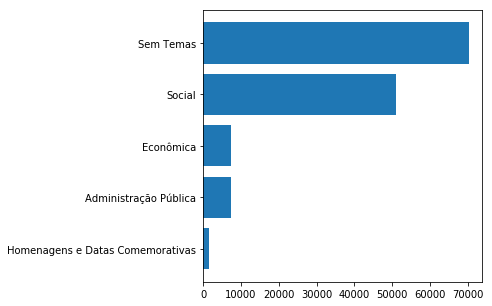

Homenagens e Datas Comemorativas     1488
Administração Pública                7300
Econômica                            7443
Social                              50943
Sem Temas                           70338
dtype: int64

<Figure size 360x360 with 0 Axes>

In [11]:
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 5)

labels = ['Administração Pública','Econômica','Homenagens e Datas Comemorativas','Social']
freq_labels = {label: len(prop[prop.tema_upperclass.str.contains(label)]) for label in labels}
freq_labels['Sem Temas'] = len(prop[prop.tema_upperclass_category == 0])
freq_labels = pd.Series(freq_labels).sort_values()

plt.barh(freq_labels.index,freq_labels.values)
plt.show()

plt.savefig('dist_temas_eda.png', dpi=400)
freq_labels

In [12]:
dataset = prop[prop.tema_upperclass_category != 0][['ementa', 'tema_upperclass_category']]

print('\nNumber of propositions with theme: {}'.format(len(dataset)))
print('Percent of propositions with theme of the total: {}%'.format(round(100*len(dataset)/(len(prop)), 4)))


Number of propositions with theme: 62179
Percent of propositions with theme of the total: 46.9215%


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62179 entries, 14 to 132516
Data columns (total 2 columns):
ementa                      62179 non-null object
tema_upperclass_category    62179 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


### Choosing feature `ementa`

We've choose this feature because it has the resume of the proposition and pratically all of the propositions have this field (99,9985%).

In [14]:
s_ind = prop[prop['ementa'].isnull()]

print('\nPropositions without ementa: {}'.format(len(s_ind)))
print('Percent of proposition without ementa of the total: {}%'.format(round(100*len(s_ind)/(len(prop)), 4)))


Propositions without ementa: 2
Percent of proposition without ementa of the total: 0.0015%


In [15]:
s_ind

,id,capnum,datacaptura,nomeproposicao,idproposicao,idproposicaoprincipal,nomeproposicaoorigem,tipoproposicao,tema,ementa,...,indexacao,situacao,linkinteiroteor,apensadas,tipo_proposicao,tipo_situacao,tipo_autor,outros_poderes,tema_upperclass,tema_upperclass_category
109025,269486,34,2015-11-07 21:10:16,PL 223/1946,537493,None,None,Projeto de Lei,None,None,...,None,MESA - Arquivada,None,None,PL,Arquivada,Deputados (as),0,nan,0
112621,298992,35,2015-11-08 03:57:22,PL 4864/1954,605771,None,None,Projeto de Lei,None,None,...,None,MESA - Arquivada,None,None,PL,Arquivada,Deputados (as),0,nan,0


#### Since we only have 2 propositions with no `ementa`, we'll discard those.

In [16]:
prop = prop.dropna(subset=['ementa'])

### Preprocessing data

In [17]:
my_stop_words = open('stopwords-pt.txt', 'r')
my_stop_words = my_stop_words.read()

In [18]:
dataset['ementa'].tail()

132512    Altera o Decreto-lei nº 167, de 1967, que "dis...
132513    Altera a Lei Complementar nº 93, de 4 de fever...
132514    Dispõe sobre incentivo fiscal na concessão de ...
132515    Altera a Lei nº 10.098, de 19 de dezembro de 2...
132516    Altera a Lei nº 8.899, de 1994, para dispor so...
Name: ementa, dtype: object

In [19]:
def pre_process(feature):
    
    # lower case
    feature = feature.str.lower()
    
    # remove punctuation with regex
    feature = feature.apply(lambda x: re.sub('[^\w\s]','',x))
    
    # remove digits with regex
    feature = feature.apply(lambda x: re.sub('\d+','',x))
    
    # remove accents with regex
    feature = feature.apply(lambda x: unidecode.unidecode(x))
    
    # remove stopwords
    stopwords = [x.strip() for x in my_stop_words.split('\n')]
    stopwords.extend(['', 'sobre', 'sob'])
    
    feature = feature.apply(lambda v: ' '.join(list(filter(lambda x: x not in stopwords, v.split(' ')))))
    
    return feature
    
dataset['ementa_filtered'] = pre_process(dataset['ementa'])
dataset.head(3)

,ementa,tema_upperclass_category,ementa_filtered
14,Aprova o ato que renova a permissão outorgada ...,1,aprova ato renova permissao outorgada rauland ...
19,Homologa ato do Conselho Monetário Nacional qu...,2,homologa ato conselho monetario nacional autor...
28,Aprova o texto da convenção relativa a liberda...,1,aprova texto convencao relativa liberdade sind...


### Separate train and test datasets

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['ementa_filtered'], 
                                                    dataset['tema_upperclass_category'],
                                                    train_size=0.8, 
                                                    test_size=0.2)

# Splitting Data choice: https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data

In [21]:
print('Size of the train set:',len(X_train),'(80% do conjunto de dados)')
print('Size of the test set:',len(X_test),'(20% do conjunto de dados)')

Size of the train set: 49743 (80% do conjunto de dados)
Size of the test set: 12436 (20% do conjunto de dados)


In [22]:
X_train.head()

5514      dispoe desmembramento conselhos federal region...
104522    estabelece normas calculo entrega controle lib...
90097     altera lei dezembro dispoe aplicacao recursos ...
17065     torna crime fato ofender honra pessoa morta ac...
116939          acrescenta paragrafo art decretolei outubro
Name: ementa_filtered, dtype: object

In [23]:
y_train.head()

5514      5
104522    2
90097     5
17065     1
116939    1
Name: tema_upperclass_category, dtype: int64

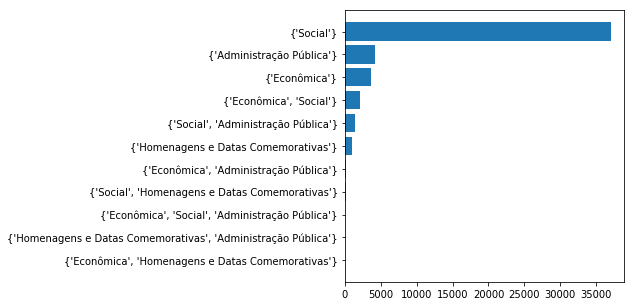

{'Social'}                                                       37001
{'Administração Pública'}                                         4152
{'Econômica'}                                                     3627
{'Econômica', 'Social'}                                           2092
{'Social', 'Administração Pública'}                               1476
{'Homenagens e Datas Comemorativas'}                              1004
{'Econômica', 'Administração Pública'}                             179
{'Social', 'Homenagens e Datas Comemorativas'}                     163
{'Econômica', 'Social', 'Administração Pública'}                    45
{'Homenagens e Datas Comemorativas', 'Administração Pública'}        3
{'Econômica', 'Homenagens e Datas Comemorativas'}                    1
Name: tema_upperclass_category, dtype: int64

In [24]:
freq_labels_train = y_train.value_counts(ascending=True)
freq_labels_train.index = [tema_upperclass_categories[i] for i in freq_labels_train.index]

plt.barh(freq_labels_train.index,
         freq_labels_train.values)

plt.show()
freq_labels_train.sort_values(ascending=False)

## Vector space models

### Bag of Words

Since the least classes have only 1 and 4 propositions, consider the words appearing in all documents would leave us with 25k word features. Therefore, we've choose the  minimum number of documents a word must be in as 25 (more than a half of the third least class), descrescing the word feature to 2.6k.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(min_df=25, 
                      lowercase=True, 
                      ngram_range=(1,1),
                      analyzer = "word")

train_bow = bow.fit_transform(X_train)
train_bow

<49743x2651 sparse matrix of type '<class 'numpy.int64'>'
	with 599986 stored elements in Compressed Sparse Row format>

In [26]:
words_freq_train = pd.DataFrame(train_bow.toarray(), 
                                index=X_train.index, 
                                columns=bow.get_feature_names())

words_freq_train['category'] = y_train
words_freq_train.head()

,abastecimento,abatimento,aberta,aberto,abertura,abono,abrangencia,abre,abril,abuso,...,xv,xvi,xviii,xxi,xxxiii,zero,zona,zonas,zpe,category
5514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
104522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
90097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
17065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
116939,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


  0%|          | 0/11 [00:00<?, ?it/s]

Populating the interactive namespace from numpy and matplotlib


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


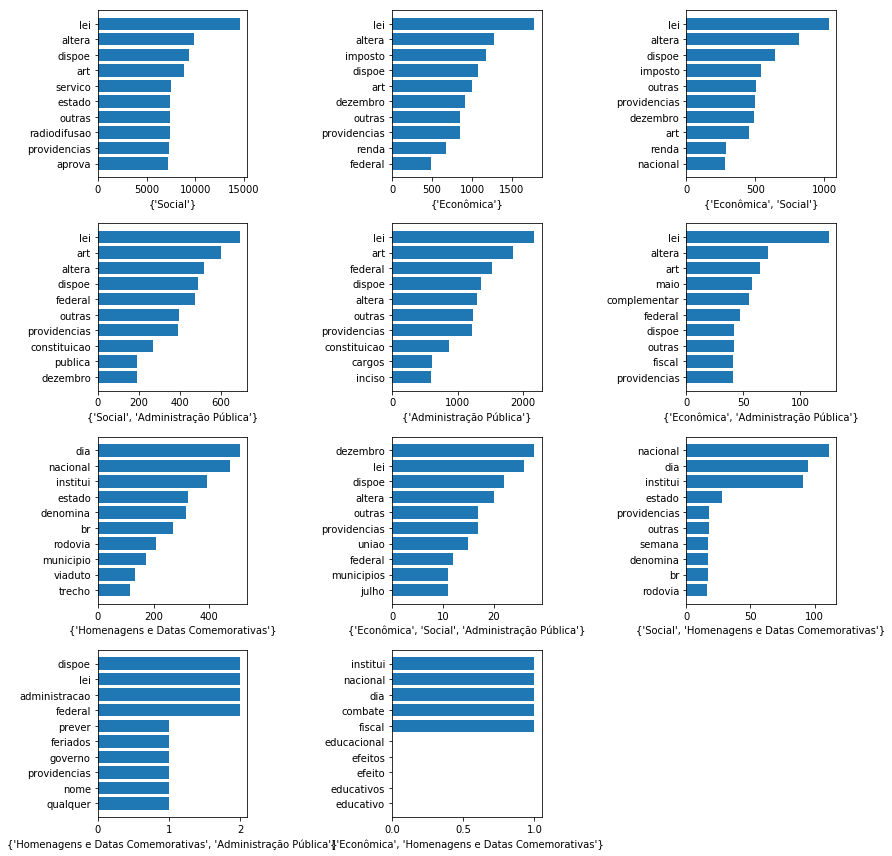

In [27]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)

from tqdm import tqdm

i = 1

categories = [x for x in category_to_tema_upperclass if x != 0]

for category in tqdm(categories):
    
    df = words_freq_train[words_freq_train['category'] == category][words_freq_train.columns[:-1]].sum()
    df = df.sort_values()[-10:]    
    
    plt.subplot(4, 3, i)
    plt.barh(df.index, df.values)
    plt.xlabel(category_to_tema_upperclass[category])

    i +=1
    
plt.tight_layout()
plt.show()

### TFIDF vetorizer

We're using the same minimum number of docs parameter on TFIDF as we've used on BOW.

In [28]:
from sklearn.feature_extraction import text 

tfidf = text.TfidfVectorizer(min_df=25,        # minimum numbers of documents a word must be present in to be kept
                             norm='l2',             # feature vectors have a euclidian norm of 1
                             ngram_range=(1, 1),    # consider only unigram
                             encoding='latin-1')

train_tfidf = tfidf.fit_transform(X_train)
train_tfidf

<49743x2651 sparse matrix of type '<class 'numpy.float64'>'
	with 599986 stored elements in Compressed Sparse Row format>

In [29]:
words_freq_train_tfidf = pd.DataFrame(train_tfidf.toarray(), 
                                index=X_train.index, 
                                columns=tfidf.get_feature_names())

words_freq_train_tfidf['category'] = y_train
words_freq_train_tfidf.head()

,abastecimento,abatimento,aberta,aberto,abertura,abono,abrangencia,abre,abril,abuso,...,xv,xvi,xviii,xxi,xxxiii,zero,zona,zonas,zpe,category
5514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
104522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
90097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
17065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
116939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Learning Models

#### Score metrics (for futher work)

In [30]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg")

#### In this work, we've used the accuracy score to evaluate the models performance, it considers the items correctly classified from the total.

In [31]:
def plot_cv_scores(clf, hyperpar_range, scores_avg, scores_std):
    
    plt.clf()

    l_avg, = plt.semilogx(hyperpar_range, scores_avg, label='avg')
    l_std, = plt.semilogx(hyperpar_range, np.array(scores_avg) + np.array(scores_std), 'b--', label='std')
    plt.semilogx(hyperpar_range, np.array(scores_avg) - np.array(scores_std), 'b--')
    
    plt.legend(handles=[l_avg, l_std], loc=1)

    locs, labels = plt.yticks()
    plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))

    plt.ylabel('CV Accuracy Score')
    plt.xlabel('Hyperparameter')

    plt.show()

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

def plot_confusion_matrix(conf_mat, classes):
    
    fig, ax = plt.subplots(figsize=(12,12))
    conf_mat = conf_mat/(conf_mat.sum(axis=1))[:,None]
    sns.heatmap(conf_mat,annot=True, 
                xticklabels=classes, 
                yticklabels=classes)

    plt.ylabel('True')
    plt.xlabel('Predicted')
    return plt.show()

def clf_eval(clf, X, y_true, classes=[0,1]):
    
    y_pred = clf.predict(X)
    print('Classification Report: \n{}'.format(classification_report(y_true, y_pred, labels=np.unique(y_pred))))
        
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy Score: {}'.format(accuracy))
    
    clf_matrix = confusion_matrix(y_true, y_pred, classes)
    plot_confusion_matrix(clf_matrix, classes)
    
    return accuracy

### Logistic Regression with BoW

#### Unbalanced weights

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Classification Report: 
             precision    recall  f1-score   support

          1       0.87      0.96      0.92      9244
          2       0.67      0.61      0.64       915
          3       0.43      0.15      0.22       516
          4       0.32      0.07      0.11       343
          5       0.64      0.52      0.57      1033
          6       0.21      0.05      0.09        56
          7       0.65      0.72      0.69       265
          8       0.50      0.08      0.14        12
          9       0.50      0.04      0.07        51

avg / total       0.79      0.83      0.80     12435

Accuracy Score: 0.827356063042779


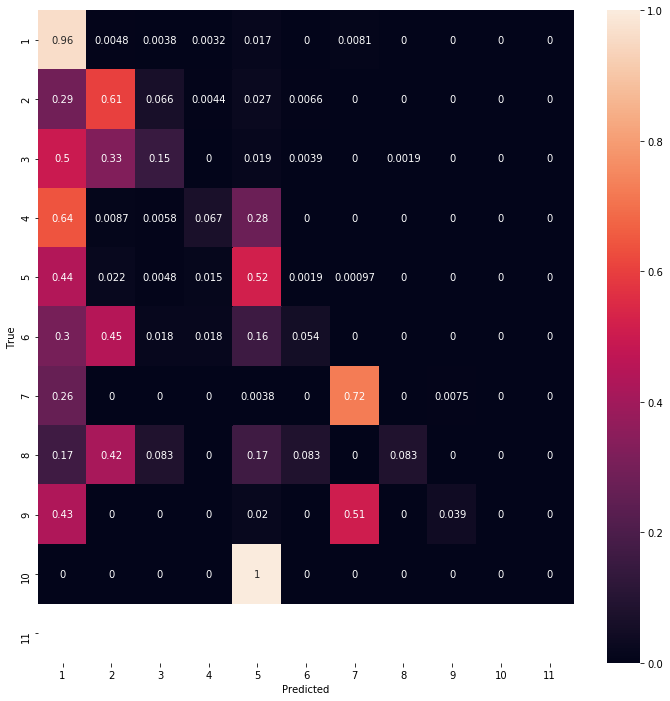

In [33]:
from sklearn.linear_model import LogisticRegression
np.seterr(divide='ignore', invalid='ignore')

clf_lr = LogisticRegression(penalty='l2', class_weight=None, n_jobs=-1)

clf_lr.fit(train_bow, y_train)

test_bow = bow.transform(X_test)

eval_lr = clf_eval(clf_lr, test_bow, y_test, categories)

#### Checking the results with balanced classes

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Classification Report: 
             precision    recall  f1-score   support

          1       0.94      0.88      0.91      9244
          2       0.63      0.64      0.64       915
          3       0.33      0.32      0.32       516
          4       0.17      0.24      0.20       343
          5       0.54      0.64      0.58      1033
          6       0.12      0.29      0.17        56
          7       0.55      0.85      0.67       265
          8       0.02      0.08      0.03        12
          9       0.12      0.16      0.14        51
         10       0.00      0.00      0.00         1
         11       0.00      0.00      0.00         0

avg / total       0.82      0.79      0.80     12436

Accuracy Score: 0.7916532647153426


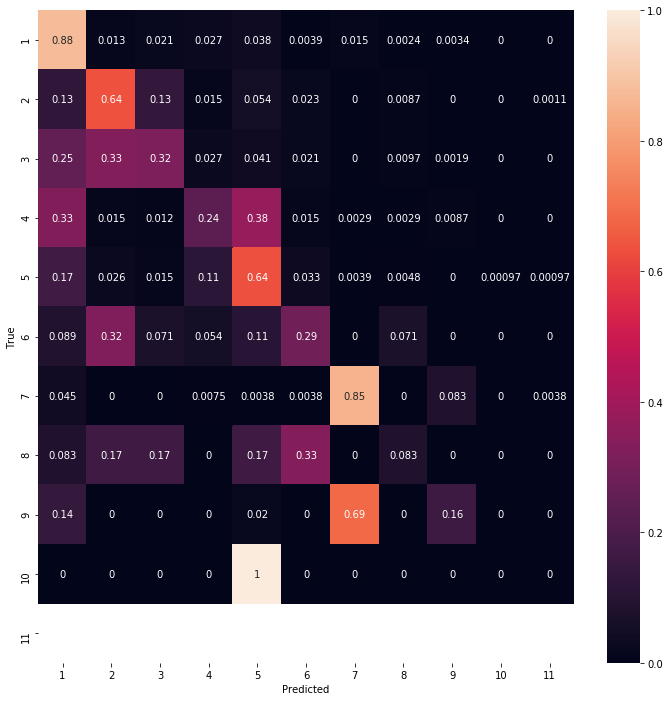

In [34]:
clf_lr_bal = LogisticRegression(penalty='l2', class_weight='balanced', n_jobs=-1)
clf_lr_bal.fit(train_bow, y_train)

eval_lr_bal = clf_eval(clf_lr_bal, test_bow, y_test, categories)

### LinearSVC model with TFIDF

The LinearSVC model has a parameter of error penalty named $C$, 
a regularization term that identifies how large we'll set the margin searator. 

We'll optimize this hyperparameter with k-fold cross validation using 5 subsamples.

#### Unbalanced weights


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)

 10%|█         | 1/10 [00:04<00:38,  4.23s/it]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 20%|██        | 2/10 [00:07<00:31,  3.97s/it]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 30%|███       | 3/10 [00:12<00:28,  4.13s/it]

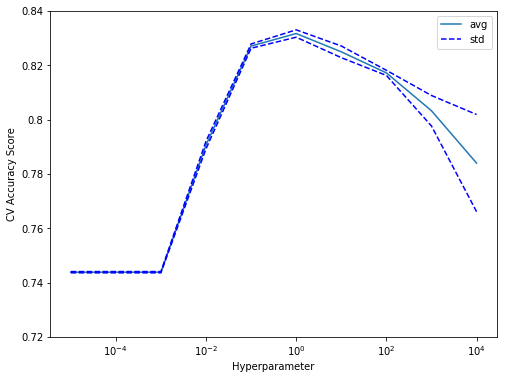

In [40]:
pylab.rcParams['figure.figsize'] = (8,6)

import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

K = 5                                    # Number of folds to split train-validation
C_range = [10**i for i in range(-5,5)]   # Range for hyperparameter C 

accuracy_scores_avg = list()
accuracy_scores_std = list()

for C in tqdm(C_range):
    
    clf_svc = LinearSVC(C=C, tol=1e-05, class_weight=None)
 
    this_accuracy_score = cross_val_score(clf_svc, train_tfidf, y_train, n_jobs=-1, cv=K, scoring='accuracy')

    accuracy_scores_avg.append(np.mean(this_accuracy_score)) # accuracy score avg 
    accuracy_scores_std.append(np.std(this_accuracy_score))  # accuracy score std

plot_svc_params = (clf_svc, C_range, accuracy_scores_avg, accuracy_scores_std)
plot_cv_scores(*plot_svc_params)

Selected Hyperparameter: 1
Classification Report: 
             precision    recall  f1-score   support

          1       0.88      0.96      0.92      9244
          2       0.66      0.65      0.66       915
          3       0.46      0.14      0.22       516
          4       0.36      0.03      0.06       343
          5       0.64      0.56      0.60      1033
          6       0.38      0.05      0.09        56
          7       0.63      0.75      0.68       265
          8       0.50      0.08      0.14        12
          9       0.60      0.06      0.11        51

avg / total       0.80      0.83      0.81     12435

Accuracy Score: 0.8324220006432936


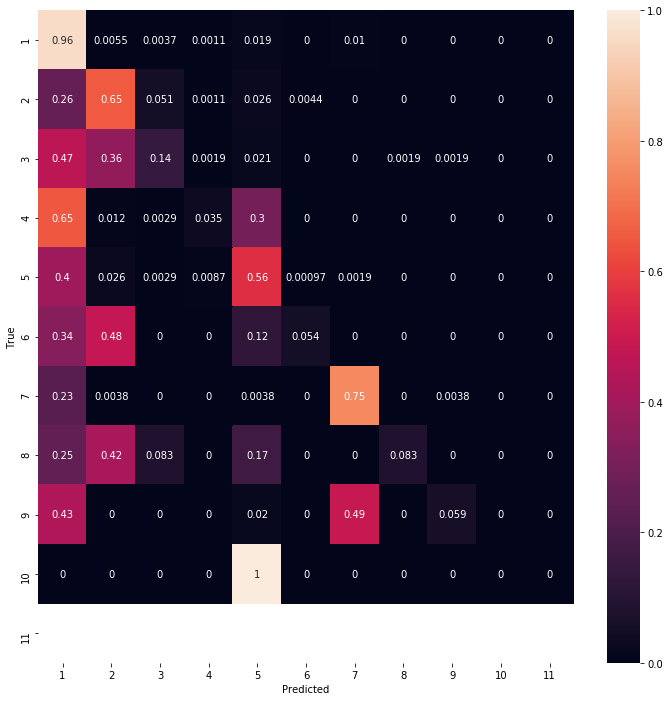

In [41]:
best_choice = C_range[accuracy_scores_avg.index(max(accuracy_scores_avg))]
print("Selected Hyperparameter:", best_choice)

clf_svc = LinearSVC(C=best_choice, tol=1e-05, class_weight=None)
clf_svc.fit(train_tfidf, y_train)

test_tfidf = tfidf.transform(X_test)
eval_svc = clf_eval(clf_svc, test_tfidf, y_test, categories)

#### Balanced weights

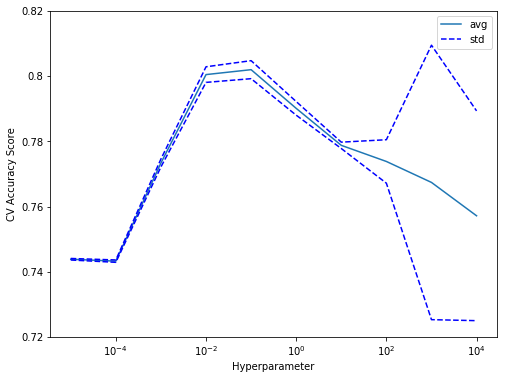

In [45]:
pylab.rcParams['figure.figsize'] = (8,6)

K = 5                                    # Number of folds to split train-validation 
C_range = [10**i for i in range(-5,5)]   # Range for hyperparameter C 

accuracy_scores_avg = list()
accuracy_scores_std = list()

for C in tqdm(C_range):
    
    clf_svc_bal = LinearSVC(C=C, tol=1e-05, class_weight='balanced')
 
    this_accuracy_score = cross_val_score(clf_svc_bal, train_tfidf, y_train, n_jobs=-1, cv=K, scoring='accuracy')

    accuracy_scores_avg.append(np.mean(this_accuracy_score)) # accuracy score avg 
    accuracy_scores_std.append(np.std(this_accuracy_score)) # accuracy score std
    
plot_svc_params = (clf_svc_bal, C_range, accuracy_scores_avg, accuracy_scores_std)
plot_cv_scores(*plot_svc_params)

Selected Hyperparameter: 0.1
Classification Report: 
             precision    recall  f1-score   support

          1       0.94      0.88      0.91      9244
          2       0.63      0.66      0.64       915
          3       0.33      0.29      0.31       516
          4       0.20      0.21      0.21       343
          5       0.55      0.65      0.60      1033
          6       0.09      0.32      0.14        56
          7       0.55      0.88      0.68       265
          8       0.03      0.17      0.05        12
          9       0.10      0.14      0.11        51
         10       0.00      0.00      0.00         1

avg / total       0.82      0.80      0.81     12436

Accuracy Score: 0.795030556449019


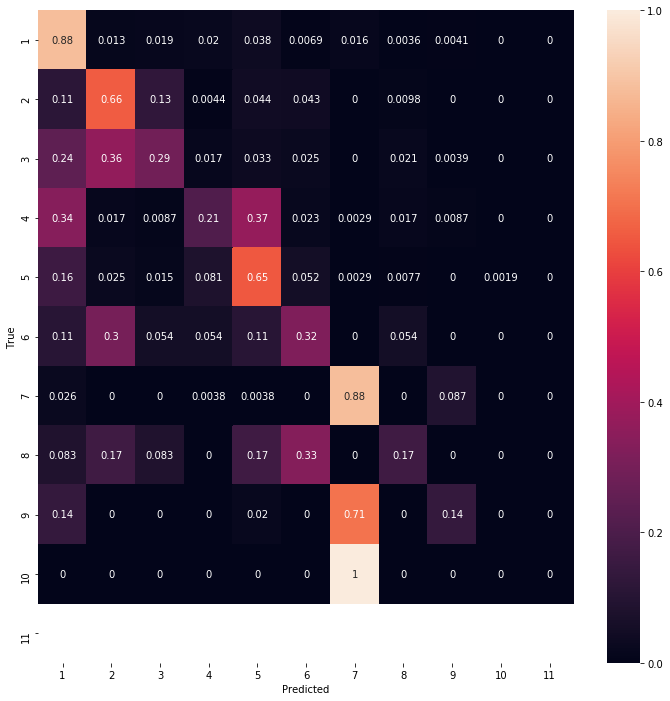

In [46]:
best_choice = C_range[accuracy_scores_avg.index(max(accuracy_scores_avg))]
print("Selected Hyperparameter:", best_choice)

clf_svc_bal = LinearSVC(C=best_choice, tol=1e-05, class_weight='balanced')
clf_svc_bal.fit(train_tfidf, y_train)

eval_svc_bal = clf_eval(clf_svc_bal, test_tfidf, y_test, categories)

### Random Forest with TFIDF

The Random Forest model has a parameter called `n_estimators`, that allows us to choose the number of decision trees to run. 

We'll optimize this hyperparameter with k-fold cross validation using 5 subsamples.

#### Unbalanced weights

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 20%|██        | 1/5 [00:03<00:15,  3.88s/it]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 40%|████      | 2/5 [00:24<00:36, 12.10s/it]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 60%|██████    | 3/5 [01:22<00:55, 27.60s/it]/usr/l

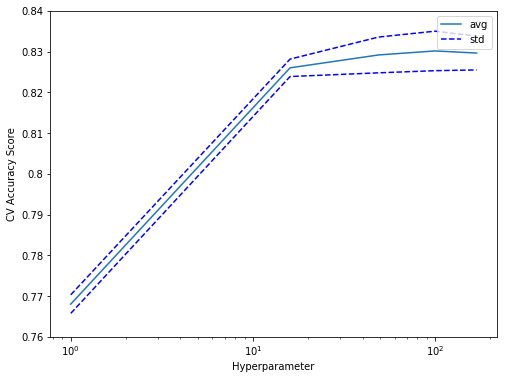

In [47]:
pylab.rcParams['figure.figsize'] = (8,6)

from sklearn.ensemble import RandomForestClassifier

K = 5                                          # Number of folds to split train-validation
n_tree_range = [i**2 for i in range(1,14,3)]   # Range for hyperparameter n_estimators

accuracy_scores_avg = list()
accuracy_scores_std = list()

for n in tqdm(n_tree_range):
    
    clf_rf =  RandomForestClassifier(n_estimators=n, class_weight=None)
 
    this_accuracy_score = cross_val_score(clf_rf, train_tfidf, y_train, n_jobs=-1, cv=K, scoring='accuracy')

    accuracy_scores_avg.append(np.mean(this_accuracy_score)) # accuracy score avg 
    accuracy_scores_std.append(np.std(this_accuracy_score)) # accuracy score std
    
plot_rf_params = (clf_rf, n_tree_range, accuracy_scores_avg, accuracy_scores_std)
plot_cv_scores(*plot_rf_params)

Selected Hyperparameter: 100
Classification Report: 
             precision    recall  f1-score   support

          1       0.88      0.96      0.92      9244
          2       0.66      0.63      0.64       915
          3       0.48      0.19      0.27       516
          4       0.35      0.08      0.12       343
          5       0.66      0.55      0.60      1033
          6       0.30      0.05      0.09        56
          7       0.64      0.71      0.67       265
          8       0.50      0.17      0.25        12
          9       0.29      0.04      0.07        51

avg / total       0.80      0.83      0.81     12435

Accuracy Score: 0.8295271791572854


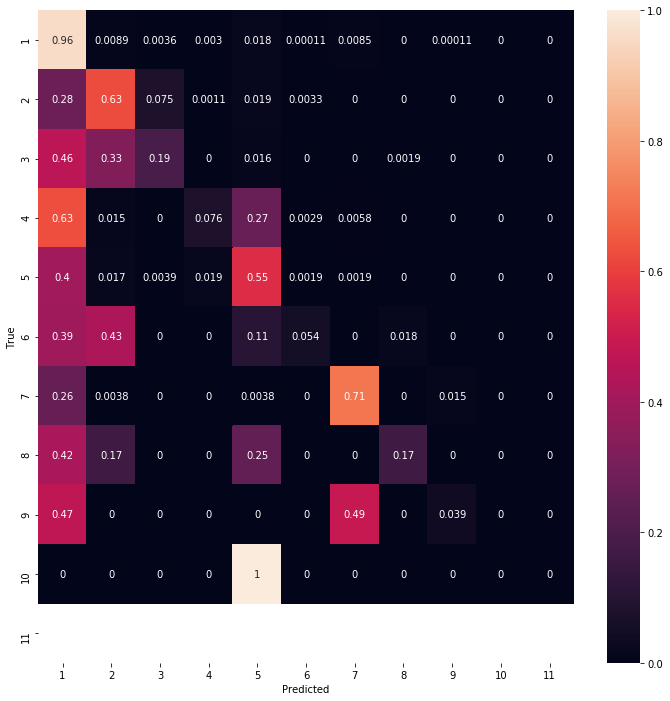

In [48]:
best_choice = n_tree_range[accuracy_scores_avg.index(max(accuracy_scores_avg))]
print("Selected Hyperparameter:", best_choice)

clf_rf = RandomForestClassifier(n_estimators=best_choice, class_weight=None)
clf_rf.fit(train_tfidf, y_train)

eval_rf = clf_eval(clf_rf, test_tfidf, y_test, categories)

#### Balanced weights

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 20%|██        | 1/5 [00:03<00:14,  3.71s/it]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 40%|████      | 2/5 [00:21<00:32, 10.89s/it]/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 60%|██████    | 3/5 [01:22<00:54, 27.38s/it]/usr/l

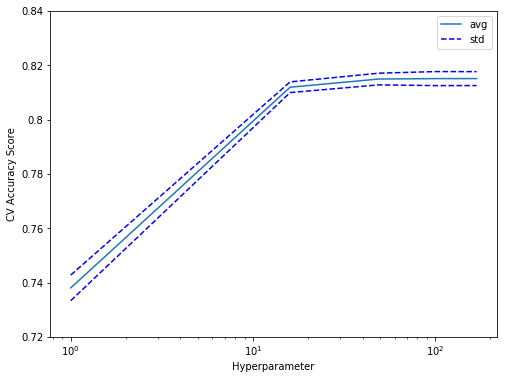

In [49]:
pylab.rcParams['figure.figsize'] = (8,6)

from sklearn.ensemble import RandomForestClassifier

K = 5                                          # Number of folds to split train-validation
n_tree_range = [i**2 for i in range(1,14,3)]     # Range for hyperparameter C 

accuracy_scores_avg = list()
accuracy_scores_std = list()

for n in tqdm(n_tree_range):
    
    clf_rf_bal =  RandomForestClassifier(n_estimators=n, class_weight='balanced')
 
    this_accuracy_score = cross_val_score(clf_rf_bal, train_tfidf, y_train, n_jobs=-1, cv=K, scoring='accuracy')

    accuracy_scores_avg.append(np.mean(this_accuracy_score)) # accuracy score avg 
    accuracy_scores_std.append(np.std(this_accuracy_score)) # accuracy score std

plot_rf_bal_params = (clf_rf_bal, n_tree_range, accuracy_scores_avg, accuracy_scores_std)
plot_cv_scores(*plot_rf_bal_params)

Selected Hyperparameter: 100
Classification Report: 
             precision    recall  f1-score   support

          1       0.86      0.95      0.90      9244
          2       0.67      0.53      0.59       915
          3       0.43      0.17      0.24       516
          4       0.24      0.08      0.11       343
          5       0.63      0.51      0.56      1033
          6       0.14      0.05      0.08        56
          7       0.64      0.74      0.68       265
          8       0.29      0.17      0.21        12
          9       0.14      0.04      0.06        51

avg / total       0.78      0.81      0.79     12435

Accuracy Score: 0.8119974268253458


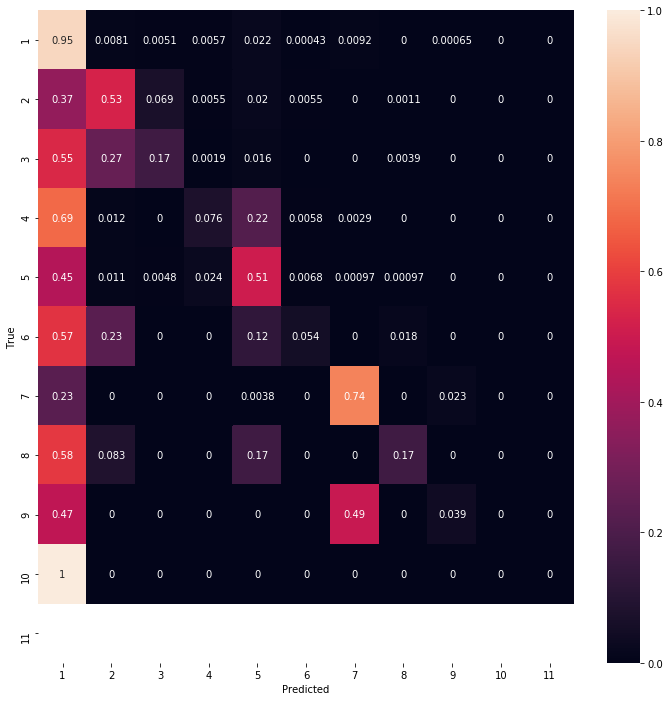

In [50]:
best_choice = n_tree_range[accuracy_scores_avg.index(max(accuracy_scores_avg))]
print("Selected Hyperparameter:", best_choice)

clf_rf_bal = RandomForestClassifier(n_estimators=best_choice, class_weight='balanced')
clf_rf_bal.fit(train_tfidf, y_train)

eval_rf_bal = clf_eval(clf_rf_bal, test_tfidf, y_test, categories)

## Comparing the models by accuracy

In [65]:
pd.Series(models_accuracy,models_label)

RegLog s/ bal.       0.827356
RegLog. c/ bal.      0.791653
LinearSVC s/ bal.    0.832422
LinearSVC c/bal      0.795031
RandomF. s/ bal      0.829527
RandomF. c/ bal      0.811997
dtype: float64

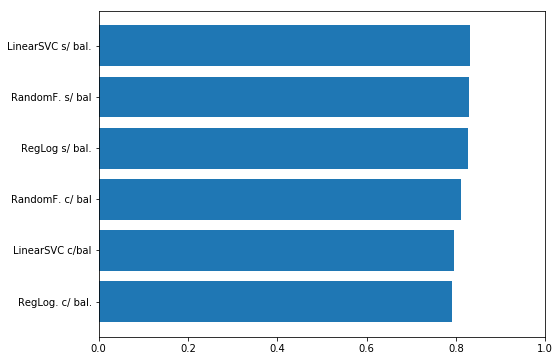

LinearSVC s/ bal.    0.832422
RandomF. s/ bal      0.829527
RegLog s/ bal.       0.827356
RandomF. c/ bal      0.811997
LinearSVC c/bal      0.795031
RegLog. c/ bal.      0.791653
dtype: float64


In [68]:
models_label = ['RegLog s/ bal.', 'RegLog. c/ bal.', 
                'LinearSVC s/ bal.', 'LinearSVC c/bal',
                'RandomF. s/ bal', 'RandomF. c/ bal']
models_accuracy = [eval_lr, eval_lr_bal,
                   eval_svc, eval_svc_bal,
                   eval_rf, eval_rf_bal]

models_score = pd.Series(models_accuracy,models_label).sort_values()


plt.barh(models_score.index,models_score.values)
axes = plt.gca()
axes.set_xlim([0,1])
plt.show()

print(models_score.sort_values(ascending=False))